In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iowa-liquor-mining/liquor.csv


Import extra libraries: matplotlib, scipy, seaborn

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

#pd.options.display.max_rows = 1000
#pd.options.display.max_columns = 20

Dataset directory

In [3]:
dfinputdir = '/kaggle/input/iowa-liquor-mining/liquor.csv'

Preprocessing: 'Store Location'. Calculate % of rows that contain empty fields (is null). Nearly 10% of values in this attribute are missing from a sample size of 1 million.

In [4]:
colnan = ['Store Location']
dfnan = pd.read_csv(dfinputdir,usecols=colnan,nrows=1000000)
sumnan = dfnan.isnull().sum()
print((sumnan/1000000)*100)

Store Location    9.7143
dtype: float64


Read dataset into pandas dataframe. This is a subset of the dataset (1 million rows) with 5 numerical attributes: Sale, Pack, Bottles Sold, Bottle Cost, and Bottle Volume.

In [5]:
cols = ['Sale (Dollars)','Pack','Bottles Sold','State Bottle Cost','State Bottle Retail','Bottle Volume (ml)','Volume Sold (Liters)']
df = pd.read_csv(dfinputdir,usecols=cols,nrows=1000000)

Proprocessing step #1 - view info of dataframe.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Pack                  1000000 non-null  int64  
 1   Bottle Volume (ml)    1000000 non-null  int64  
 2   State Bottle Cost     1000000 non-null  float64
 3   State Bottle Retail   1000000 non-null  float64
 4   Bottles Sold          1000000 non-null  int64  
 5   Sale (Dollars)        1000000 non-null  float64
 6   Volume Sold (Liters)  1000000 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 53.4 MB


Pandas interprets pack, bottle volume, and bottles sold as integer datatypes. Bottle cost and sale are float datatypes.
Outlier analysis focuses on the Sale attribute.

In [7]:
print(df['Sale (Dollars)'].describe())
#plt.figure(figsize=(9, 8))


count    1000000.000000
mean         160.397008
std          590.427288
min            1.340000
25%           41.580000
50%           86.280000
75%          163.080000
max       250932.000000
Name: Sale (Dollars), dtype: float64


The maximum value in Sale is more than 400 standard deviations away from the mean. Conventionally, outliers are detected at >=3 standard deviations from the mean (99.7% of data lies within 3 std). This is appears to be an individual, global outlier.

In [8]:
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    sd_x = np.std(x)
    numerator = max(abs(x-mean_x))
    g_calculated = numerator/sd_x
    print("Grubbs Calculated Value:",g_calculated)
    t_value = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
    g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))
    print("Grubbs Critical Value:",g_critical)
    if g_critical > g_calculated:
        print("The calculated value is less than the critical value: by Grubbs test there are no outliers\n")
    else:
        print("The calculated value is greater than the critical value: by Grubbs test there is an outlier\n")

In [9]:
grubbs_test(df['Sale (Dollars)'].to_numpy())

Grubbs Calculated Value: 424.7292319025872
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [10]:
grubbs_test(df['Pack'].to_numpy())

Grubbs Calculated Value: 13.676612496971057
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [11]:
grubbs_test(df['Bottles Sold'].to_numpy())

Grubbs Calculated Value: 361.10812175893466
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [12]:
grubbs_test(df['State Bottle Cost'].to_numpy())

Grubbs Calculated Value: 183.0052638196804
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [13]:
grubbs_test(df['Bottle Volume (ml)'].to_numpy())

Grubbs Calculated Value: 5.054871460799461
Grubbs Critical Value: 5.45127130224995
The calculated value is less than the critical value: by Grubbs test there are no outliers



In [14]:
grubbs_test(df['State Bottle Retail'].to_numpy())

Grubbs Calculated Value: 183.04128584929435
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [15]:
grubbs_test(df['Volume Sold (Liters)'].to_numpy())

Grubbs Calculated Value: 314.890380194105
Grubbs Critical Value: 5.45127130224995
The calculated value is greater than the critical value: by Grubbs test there is an outlier



In [16]:
#Z-score based outlier detection
z_out=[]
def Zscore_outlier(df):
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            z_out.append(i)
    print("Outliers:",len(z_out))
Zscore_outlier(df['Sale (Dollars)'])
df_zo = pd.DataFrame (z_out, columns = ['outliers'])
#print(df_zo['outliers'].describe())

df1 = df[df['Sale (Dollars)'].isin(z_out) == False]
print(df1['Sale (Dollars)'].describe())

Outliers: 6129
count    993871.000000
mean        133.593113
std         170.565189
min           1.340000
25%          41.250000
50%          85.500000
75%         162.240000
max        1931.280000
Name: Sale (Dollars), dtype: float64


In [17]:
#IQR based outlier detection
iqr_out=[]
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            iqr_out.append(i)
    print("Outliers:",len(iqr_out))
iqr_outliers(df['Sale (Dollars)'])
df_iqr = pd.DataFrame (iqr_out, columns = ['outliers'])
#print(df_iqr['outliers'].describe())

df2 = df[df['Sale (Dollars)'].isin(iqr_out) == False]
print(df2['Sale (Dollars)'].describe())

Outliers: 66710
count    933290.000000
mean        100.755738
std          78.098339
min           1.340000
25%          38.700000
50%          78.660000
75%         144.000000
max         345.120000
Name: Sale (Dollars), dtype: float64


In [18]:
#Winsorization based outlier detection
w_out=[]
def Winsorization_outliers(df):
    q1 = np.percentile(df , 1)
    q3 = np.percentile(df , 99)
    for i in df:
        if i > q3 or i < q1:
            w_out.append(i)
    print("Outliers:",len(w_out))
Winsorization_outliers(df['Sale (Dollars)'])

df3 = df[df['Sale (Dollars)'].isin(w_out) == False]
print(df3['Sale (Dollars)'].describe())

Outliers: 19480
count    980520.000000
mean        129.154176
std         144.963240
min           7.200000
25%          42.000000
50%          86.040000
75%         162.000000
max        1327.800000
Name: Sale (Dollars), dtype: float64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


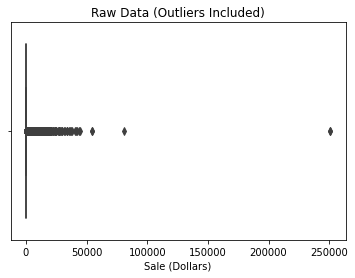

In [19]:
plt.title("Raw Data (Outliers Included)")
sns.boxplot(df['Sale (Dollars)']);

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


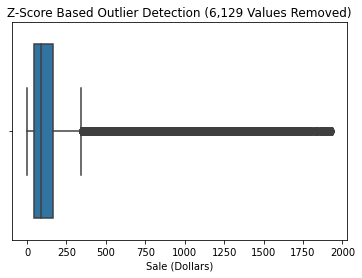

In [20]:
plt.title("Z-Score Based Outlier Detection (6,129 Values Removed)")
sns.boxplot(df1['Sale (Dollars)']);

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


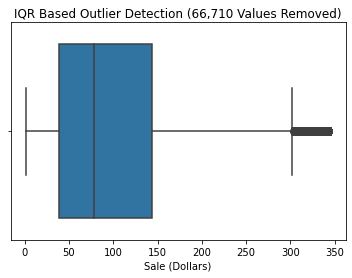

In [21]:
plt.title("IQR Based Outlier Detection (66,710 Values Removed)")
sns.boxplot(df2['Sale (Dollars)']);

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


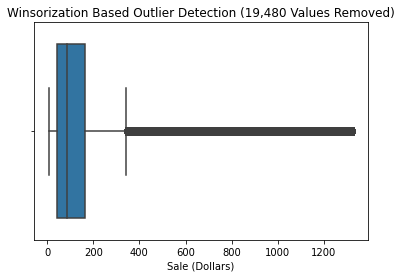

In [22]:
plt.title("Winsorization Based Outlier Detection (19,480 Values Removed)")
sns.boxplot(df3['Sale (Dollars)']);

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


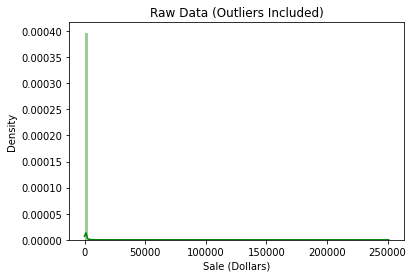

In [23]:
plt.title("Raw Data (Outliers Included)")
sns.distplot(df['Sale (Dollars)'], color='g', bins=100, hist_kws={'alpha': 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


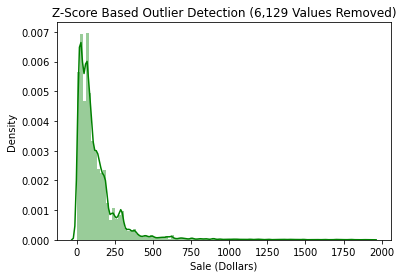

In [24]:
plt.title("Z-Score Based Outlier Detection (6,129 Values Removed)")
sns.distplot(df1['Sale (Dollars)'], color='g', bins=100, hist_kws={'alpha': 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


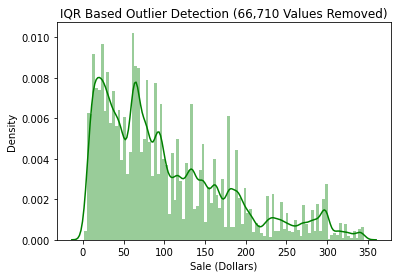

In [25]:
plt.title("IQR Based Outlier Detection (66,710 Values Removed)")
sns.distplot(df2['Sale (Dollars)'], color='g', bins=100, hist_kws={'alpha': 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


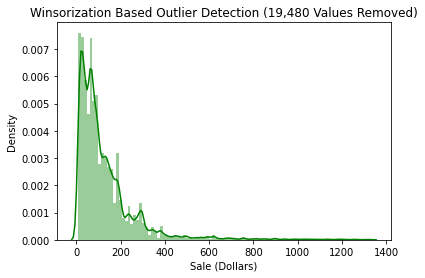

In [26]:
plt.title("Winsorization Based Outlier Detection (19,480 Values Removed)")
sns.distplot(df3['Sale (Dollars)'], color='g', bins=100, hist_kws={'alpha': 0.4});

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


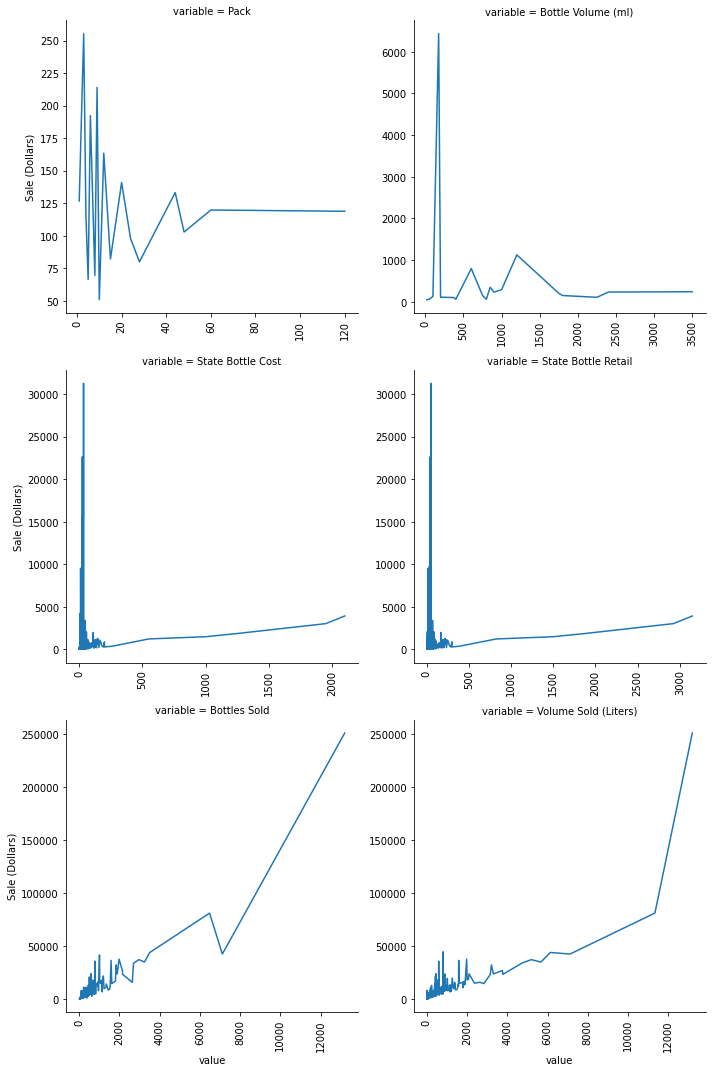

In [27]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(df, id_vars=['Sale (Dollars)'])
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "Sale (Dollars)")

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


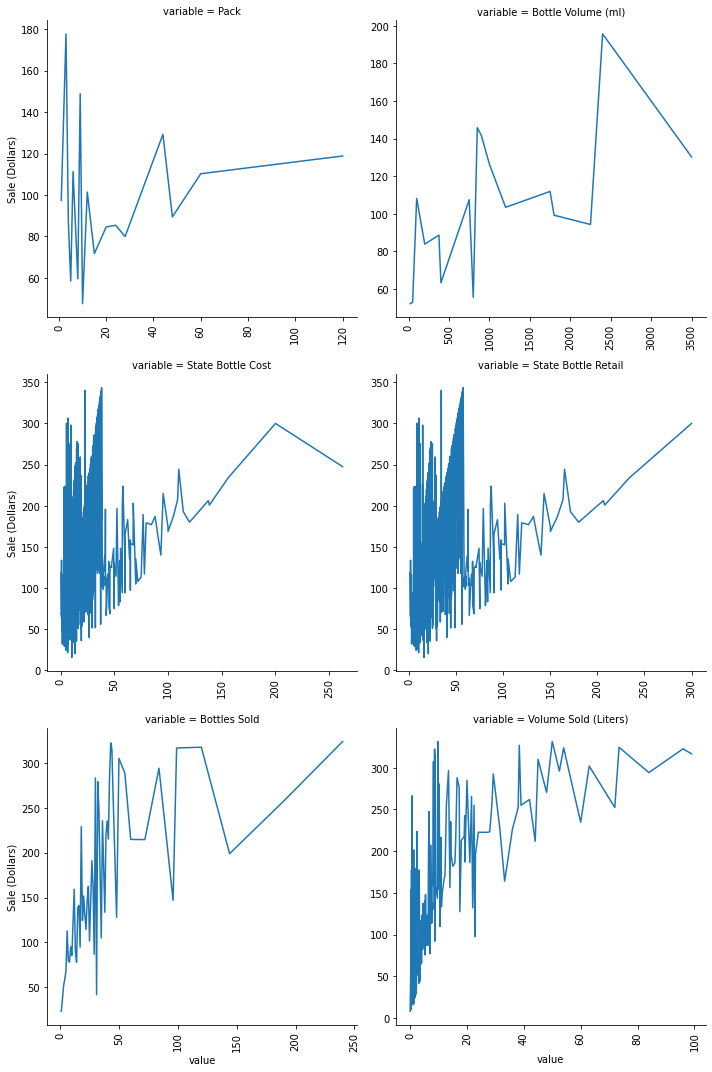

In [28]:
f = pd.melt(df2, id_vars=['Sale (Dollars)'])
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "Sale (Dollars)")

References

https://www.kaggle.com/nareshbhat/outlier-the-silent-killer

https://www.kaggle.com/dgawlik/house-prices-eda/notebook

https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

https://www.kaggle.com/rpsuraj/outlier-detection-techniques-simplified